# Red neuronal con diferentes funciones de activacion y propagación de errores hacia atrás (backpropagation)

### Tipos de funciones de activación:
Fuente: https://mlfromscratch.com/activation-functions-explained/#/
![title](https://mlfromscratch.com/content/images/2019/12/activation-functions.gif)


### Descenso del gradiente (intuición)

- La deducción no es propósito de esta notebook, pero cada nuevo paso en busca de la minimización de la función de costo, obedece la siguiente regla:

$ v -> v' = v - \eta \nabla C$, donde $v$ es $f(w, b)$ y $\eta$ la tasa de aprendizaje (tamaño de paso, learning rate)

- Se da un paso en dirección opuesta al gradiente hasta minimizar la función de costo.

- Se le llama *backpropagation* al algoritmo que realiza esto iterativamente desde la última capa hasta la primera.

Fuente: https://kevinbinz.com/2019/05/26/intro-gradient-descent/

![title](https://kevinbinz.files.wordpress.com/2019/05/dualspace_explore.gif)

- Se quiere encontrar (x,y) tal que sea un mínimo en la superficie (función de costo).

Fuente: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

![title](https://miro.medium.com/max/819/1*hUd744hDEEGx0-ypWGhrkw.gif)


![title](https://raw.githubusercontent.com/igomezv/MACS_2021_ML_basics_neural_networks/main/figures/approxTheorem.png)



# Algunos tipos de redes neuronales
Fuente: https://www.asimovinstitute.org/neural-network-zoo/
<div>
    <img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png", width="500">
</div>

## 1. Construyamos una red neuronal configurable con keras

In [1]:
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

2022-01-24 03:36:43.693453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-24 03:36:43.693468: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class neural_net:
    def __init__(self, X, Y, topology, epochs=50, lr=0.0001, bs=4, early_tol=100, scale=False):
        self.topology = topology
        self.epochs = epochs
        self.lr = lr
        self.bs = bs
        self.early_tol = early_tol
        self.scale = scale
        
        ntrain = int(0.8* len(X))
        indx = [ntrain]
        self.X_train, self.X_test = np.split(X, indx)
        self.Y_train, self.Y_test = np.split(Y, indx)
        
        if self.scale:
            self.scaler = StandardScaler()
            try:
                self.scaler.fit(X)
                self.X_train = self.scaler.transform(self.X_train)
                self.X_test = self.scaler.transform(self.X_test)
            except:
                self.scaler.fit(X.reshape(-1,1))
                self.X_train = self.scaler.transform(self.X_train.reshape(-1,1))
                self.X_test = self.scaler.transform(self.X_test.reshape(-1,1))

            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
        
        self.model = self.model()
        self.model.summary()
        
    def model(self):
        # Red neuronal
        model = K.models.Sequential()
        # Hidden layers

        for i, nodes in enumerate(self.topology):
            if i == 0:
                model.add(K.layers.Dense(self.topology[1], input_dim=self.topology[0], activation='relu'))
            elif i < len(self.topology)-2:
                model.add(K.layers.Dense(self.topology[i+1], activation='relu'))
            else:
                model.add(K.layers.Dense(self.topology[i], activation='linear'))
        optimizer = K.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model                    
    
    def train(self):
        callbacks = [K.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                               min_delta=0.0,
                                               patience=self.early_tol,
                                               restore_best_weights=True)]
        print("Entrenando, por favor, espera...")
        self.history = self.model.fit(self.X_train,
                                      self.Y_train,
                                      validation_data=(self.X_test,
                                                       self.Y_test),
                                      epochs=self.epochs, batch_size=self.bs,
                                      callbacks=callbacks, verbose=0)
        print("¡Entrenamiento terminado!")
        return self.history
    
    def get_w_and_b(self, nlayer):
        weights, biases = self.model.layers[nlayer].get_weights()
        return weights, biases
    
    def predict(self, x):
        if type(x) == type([1]):
            x = np.array(x)
        if type(x) == type(1):
            x = np.array([x])
        if self.scale:
            try:
                x = self.scaler.transform(x)
            except:
                x = self.scaler.transform(x.reshape(-1,1))
        return self.model.predict(x)
        
    def plot(self):
        plt.plot(self.history.history['loss'], label='training set')
        plt.plot(self.history.history['val_loss'], label='validation set')
        mse = np.min(self.history.history['val_loss'])
        plt.title('MSE: {} Uncertainty: {}'.format(mse, np.sqrt(mse)))
        plt.ylabel('loss function')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

## Ejemplos numéricos

### Ejemplo 1: Aprendiendo funciones

#### Analicemos si una red neuronal puede aprender las siguientes tres funciones:

* $line(x) = 2x+3$
* $quadratic(x) = x^2 +2$
* $quadtres(x_1,x_2,x_3) = x_1^2 + 2x_2 + x_3$

In [3]:
def line(x):
    return 2*x + 3 + 0.05 * np.random.rand()

def quadratic(x):
    return x**2 + 2 + 0.001 * np.random.rand()

def quadtres(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = x[i, 0]**2 + 2*x[i, 1] + x[i, 2]
    return y

In [4]:
# Descomentar función para generar datos
# fn = line
fn = quadratic
# fn = quadtres

# Seleccionar número de puntos para el dataset
npoints = 100

# Generar X
## para line y quadratic
X = np.random.rand(npoints)
## para quadtres
# X = np.random.rand(npoints, 3)

# Generar Y
Y = fn(X)

# Ver tabla de datos
## para line y quadratic
data =pd.DataFrame(zip(X,Y), columns=['x', 'y'])
## para quadtres
# data =pd.DataFrame(zip(X[:,0], X[:,1], X[:,2], Y), columns=['$x_1$', '$x_2$', '$x_3$', 'y'])
data.head(10)

,x,y
0,0.844595,2.713846
1,0.976267,2.953603
2,0.120476,2.015020
3,0.034705,2.001710
4,0.254310,2.065179
5,0.539943,2.292044
6,0.360022,2.130121
7,0.086549,2.007996
8,0.815904,2.666205
9,0.772596,2.597409


In [5]:
network = neural_net(X, Y, [1, 100, 100, 1], epochs=100, bs=16, lr=0.01, scale=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________


2022-01-24 03:36:45.198794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-24 03:36:45.198850: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-24 03:36:45.198897: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist
2022-01-24 03:36:45.199374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
network.train()

2022-01-24 03:36:45.269725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Entrenando, por favor, espera...
¡Entrenamiento terminado!


In [7]:
w, b = network.get_w_and_b(nlayer=0)
print(len(w), len(b))
print(w)

1 100
[[ 0.15434723 -0.04056934  0.22401066 -0.23075496 -0.06595625  0.22547339
  -0.16974019 -0.200212   -0.03611211 -0.09699833  0.09689888 -0.00224968
   0.02405898 -0.2396817  -0.08303833  0.12547566 -0.16778049 -0.23750146
  -0.10772877  0.1257265  -0.14537267 -0.2381867  -0.23643664 -0.15737899
   0.15920667 -0.00171809 -0.20358844  0.05513354  0.04565416  0.09569887
  -0.21888138 -0.01753356  0.17033063  0.17649071 -0.0822527   0.15688382
  -0.1969931  -0.08816835 -0.17391463 -0.1922135   0.14975178 -0.07528158
   0.19764487  0.05568675  0.15603703 -0.06408523  0.23539686  0.21161081
  -0.2420388  -0.01011179 -0.16524582 -0.18133016  0.2207967  -0.14856745
  -0.11598852 -0.23573598 -0.03818505 -0.01988162  0.21697645  0.01286681
   0.01678779 -0.04499701 -0.10224554 -0.2245193   0.08555856 -0.17432092
   0.00139552 -0.13968006  0.17917064 -0.01492966 -0.16819301  0.18349268
  -0.08645174 -0.14032759 -0.19132198  0.23897499 -0.09587091 -0.08797358
  -0.01938431 -0.06167657 -0.044

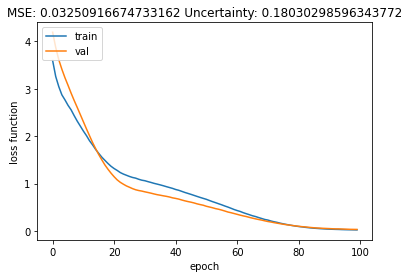

In [8]:
network.plot()

In [9]:
# new_vector = np.array([0.7, 0.5, 0.6]).reshape(1,3)
new_vector = np.array([0.7])
prediction = network.predict(new_vector)


print("Valor real: {}".format(float(fn(new_vector))))
print("Predicción: {}".format(float(prediction)))

Valor real: 2.490780593671905
Predicción: 2.1072676181793213


# Clasificación con el conjunto iris

In [10]:
data_iris = pd.read_csv('https://raw.githubusercontent.com/igomezv/DLCIMATAGS/main/data/iris/iris.data')
data_iris.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Preprocesamiento

In [11]:
data_iris["class"] = data_iris["class"].astype('category')
data_iris["class_num"] = data_iris["class"].cat.codes
data_iris

,sepallength,sepalwidth,petallength,petalwidth,class,class_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


### Iris-setosa-> 0, Iris-versicolor -> 1, Iris-virginica->2

In [12]:
X = data_iris[['sepallength', 'sepalwidth', 'petallength', 'petalwidth']]
Y = data_iris[['class_num']]
N = len(X)
X.head(), N


(   sepallength  sepalwidth  petallength  petalwidth
 0          5.1         3.5          1.4         0.2
 1          4.9         3.0          1.4         0.2
 2          4.7         3.2          1.3         0.2
 3          4.6         3.1          1.5         0.2
 4          5.0         3.6          1.4         0.2,
 150)

In [13]:
# randomize = np.random.permutation(N)
# X = X.values[randomize]
# Y = Y.values[randomize]
# Y
X = X.values
Y = Y.values

In [14]:
len(X), len(Y)

(150, 150)

#### Convertir dataframes a numpy.arrays

In [15]:
v0 = int(len(X)*0.8)
x0 = X[:v0,:]
y0 = Y[:v0]
# y = y[:500]
# X = X[:500, :]
xtest = X[v0:, :]
ytest = Y[v0:]


### Diseñar red neuronal

In [16]:
network = neural_net(x0, y0, topology=[4, 10, 10, 10, 1], lr=1e-5, bs=1, epochs=200)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


### Entrenar y evaluar rendimiento de la red neuronal

Entrenando, por favor, espera...
¡Entrenamiento terminado!


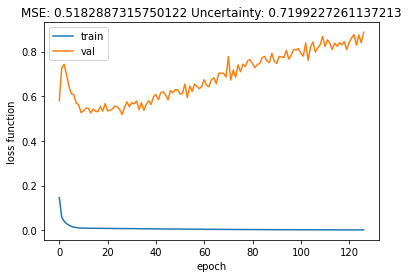

In [17]:
network.train()
network.plot()

predicción sencilla

In [18]:
test_vector = np.array([2, 9, 1, 1]).reshape(1,4)
print(np.shape(test_vector))
# galaxy 0, quasar 1, star 2
network.predict(test_vector).round()

(1, 4)


array([[-1.]], dtype=float32)

Ahora usemos los datos guardados (test set) para probar las predicciones. Hay diferentes métodos y métricas para hacer esto, sin embargo aquí haremos algo simple. Solo compararemos las predicciones con los valores reales. 

In [19]:
predictions = np.abs(network.predict(xtest).round())

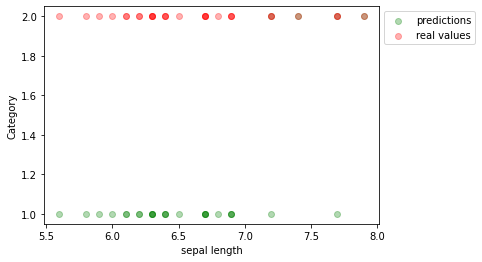

In [20]:
# aciertos = (ytest == predictions)
plt.scatter(xtest[:,0], predictions, alpha=0.3, color='green', label='predictions')
plt.scatter(xtest[:,0], ytest, alpha=0.3, color='red', label='real values')
plt.xlabel('sepal length')
plt.ylabel('Category')
plt.legend(bbox_to_anchor=(1.0,1.0))

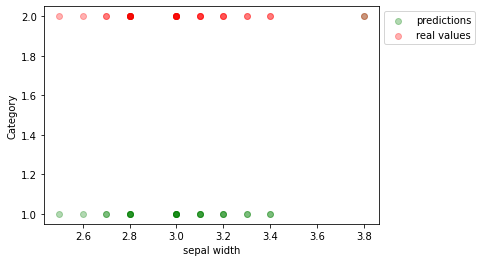

In [21]:
plt.scatter(xtest[:,1], predictions, alpha=0.3, color='green', label='predictions')
plt.scatter(xtest[:,1], ytest, alpha=0.3, color='red', label='real values')
plt.xlabel('sepal width')
plt.ylabel('Category')
plt.legend(bbox_to_anchor=(1.0,1.0))

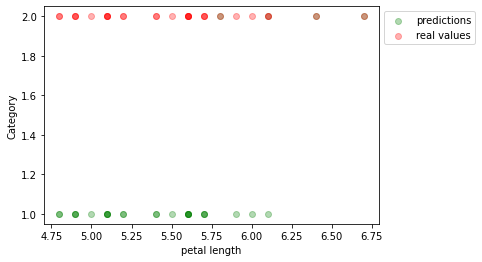

In [22]:
plt.scatter(xtest[:,2], predictions, alpha=0.3, color='green', label='predictions')
plt.scatter(xtest[:,2], ytest, alpha=0.3, color='red', label='real values')
plt.xlabel('petal length')
plt.ylabel('Category')
plt.legend(bbox_to_anchor=(1.0,1.0))

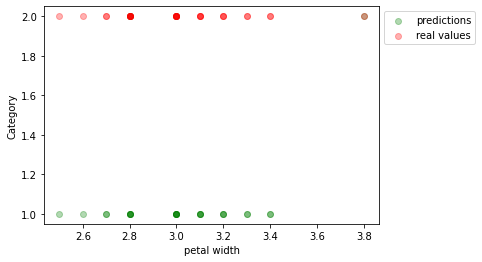

In [23]:
plt.scatter(xtest[:,1], predictions, alpha=0.3, color='green', label='predictions')
plt.scatter(xtest[:,1], ytest, alpha=0.3, color='red', label='real values')
plt.xlabel('petal width')
plt.ylabel('Category')
plt.legend(bbox_to_anchor=(1.0,1.0))

In [24]:
aciertos = (predictions == ytest)
print("Nuestra red neuronal tuvo {} aciertos de un total de {} predicciones".format(aciertos.sum(), len(predictions)))
print("Acertó en un {}%".format(aciertos.sum()/len(predictions)*100))

Nuestra red neuronal tuvo 4 aciertos de un total de 30 predicciones
Acertó en un 13.333333333333334%


## Referencias:

- Nielsen, M. A. (2015). Neural networks and deep learning (Vol. 25). San Francisco, CA: Determination press.
- https://kevinbinz.com/2019/05/26/intro-gradient-descent/
- https://mlfromscratch.com/activation-functions-explained/#/
- https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
- https://keras.io/